In [1]:
'''
PHYS 678 Problem Set 6: Fitting

The following code fits 2D functions with binned and unbinned likelihood fits
(Problem 1) and analyzes and fits optical tweezers data (Problem 2).

Authors: D. Moore
Date:   03/05/2022
'''

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit
from scipy.stats import chi2

## **Problem 1: Fitting in 2D**


In [2]:
## First, load the data from the file
data_2d = np.load('drive/MyDrive/data/2d_data.npz')
x = data_2d['x']
y = data_2d['y']

In [3]:
def gauss_2d_fit(x,y,A,mu_x,mu_y,sig_x,sig_y,rho):
  """ Function to return the value of a 2D gaussian
    Parameters:
      x,y: Arrays of x and y coordinates to evaluate at
      A: amplitude of the Gaussian
      mu_x, mu_y: Means for the x/y coordinates
      sig_x, sig_y: Sigmas for the x/y coordinates
      rho: correlation coefficient

    Return:
      Value of the 2D gaussian at the x/y coordinates
  """
  xexp = (x-mu_x)/sig_x
  yexp = (y-mu_y)/sig_y
  return A * np.exp( -1/(2*(1-rho**2)) * (xexp**2 + yexp**2 - 2*rho*xexp*yexp) )

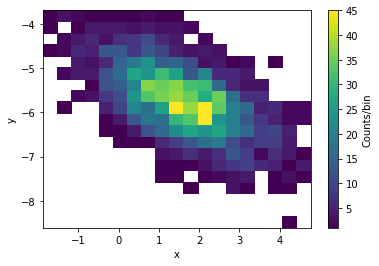

In [4]:
## We will start with a binned likelihood fit, so need to first bin the 
## data points in 2D

num_bins = 20
h, xbins_edges, ybins_edges = np.histogram2d(x, y, bins=num_bins)

## replace values of zero with np.nan to plot them as white colors
h_for_plotting = 1.0*h 
h_for_plotting[h==0] = np.nan

## Plot the 2d histogram -- note pcolormesh wants the lower left coordinates of
## each square bin
plt.figure()
plt.pcolormesh(xbins_edges[:-1], ybins_edges[:-1], h_for_plotting)
plt.colorbar(label="Counts/bin")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [5]:
def binned_likelihood(params, x, y, data):
  """ Function to calculate the negative log likelihood between the binned
      data and the model at a given set of parameters (params). This will be
      passed to the minimizer
    
    Parameters:
      params - array of fitting parameters to pass to the gauss_2d_fit function
      x,y - arrays of x and y values corresponding to the data
      data - array of observed counts

    Returns:
      Single value of the NLL for the data and model at the given params
  """
  model = gauss_2d_fit(x, y, *params)
  return np.sum( model - data*np.log(model) )

In [6]:
## make a guess for the best fit parameters based on the means and stds
## we can just put default numbers for the amplitude and correlation
init_guess = [1, np.mean(x), np.mean(y), np.std(x), np.std(y), 0]

## we will need the bin centers corresponding to each bin in order to evaluate
## the NLL at the center of the bin
xbins_cents = xbins_edges[:-1] + np.diff(xbins_edges)/2
ybins_cents = ybins_edges[:-1] + np.diff(ybins_edges)/2

xbins_grid, ybins_grid = np.meshgrid(xbins_cents, ybins_cents)

## minimize the NLL with default minimizer and parameters
min_result = minimize(binned_likelihood, init_guess, args = (xbins_grid, ybins_grid, h) )
best_params_binned = min_result.x

print("Best fit parameters (binned likelihood):")
print("A  mu_x  mu_y  sig_x sig_y rho")
print("==============================")
print(best_params_binned)

Best fit parameters (binned likelihood):
A  mu_x  mu_y  sig_x sig_y rho
[41.23879174  1.60925856 -5.71644007  1.18592587  0.73862445 -0.59601547]


In [7]:
## for plotting, we can evaluate the function on a finer grid of points
num_pts_to_plot = 100
bp = best_params_binned
nsig = 3 ## number of sigma to extend the plot to

mux, sigx = best_params_binned[1], best_params_binned[3]
muy, sigy = best_params_binned[2], best_params_binned[4]

## set range for plotting/calculating best fit function
xvals = np.linspace(mux-nsig*sigx, mux+nsig*sigx,num_pts_to_plot)
yvals = np.linspace(muy-nsig*sigy, muy+nsig*sigy,num_pts_to_plot)
xgrid, ygrid = np.meshgrid(xvals, yvals)

z_best_fit = gauss_2d_fit(xgrid, ygrid, *best_params_binned)

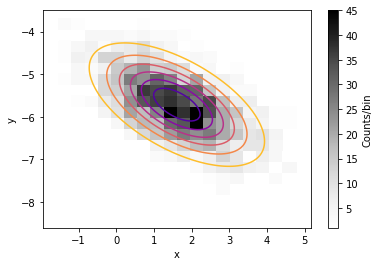

In [8]:
## Make a plot of the original histogram and the best fit as overlaid countours
plt.figure()
plt.pcolormesh(xbins_edges[:-1], ybins_edges[:-1], h_for_plotting, cmap='Greys')
plt.colorbar(label="Counts/bin")
plt.contour( xgrid, ygrid, z_best_fit, cmap='plasma_r' )
plt.xlabel("x")
plt.ylabel("y")
plt.show()

So the above fit looks pretty good -- however, it requires a choice of bins which if we don't make sufficiently small could lead to binning effects altering the best fit values. Instead we can calculate also the unbinned likelihood fit since we don't have a prohibitively large number of points to evaluate:

In [9]:
def unbinned_likelihood(params, xdata, ydata):
    """ Function to directly return the negative log likelihood for a 2D 
        gaussian. This already takes the log analytically to avoid numerical
        overflows that would occur if using the function defined previously
        and then taking the log

    Parameters:
      params - array of fitting parameters as in gauss_2d_fit function
      x,y - arrays of x and y values corresponding to the data
      xdata, ydata - array of observed counts

    Return:
      Negative Log of the 2D gaussian at the x/y coordinates
    """
    mu1, mu2, sig1, sig2, rho = params[0], params[1], params[2], params[3], params[4]
    xexp = (xdata-mu1)/sig1
    yexp = (ydata-mu2)/sig2
    NLL = 1/(2*(1-rho**2)) * (xexp**2 + yexp**2 - 2*rho*xexp*yexp) - np.log(1/(2*np.pi*sig1*sig2*np.sqrt(1-rho**2)))
    return np.sum( NLL )

In [10]:
## now the unbinned fit

# Can start with the binned fit parameters as our guess note that as implemented 
# we are ignoring the amplitude of the Gaussian for the unbinned case. If we 
# want the amplitude, we could add a term to the likelihood that counts the 
# total number of points
init_guess = best_params_binned[1:] 
min_result = minimize(unbinned_likelihood, init_guess, args = (x,y) )
best_params_unbinned = min_result.x

## now compare the best fit values between the methods
print("Best fit parameters:")
print("mu_x  mu_y  sig_x sig_y rho")
print("==============================")
print("Binned fit: ", best_params_binned[1:])
print("Unbinned fit: ", best_params_unbinned)

Best fit parameters:
mu_x  mu_y  sig_x sig_y rho
Binned fit:  [ 1.60925856 -5.71644007  1.18592587  0.73862445 -0.59601547]
Unbinned fit:  [ 2.02875122 -6.02353835  0.98219649  0.8577646  -0.59319708]


So overall the two methods give similare results, although there are some ~10% differences in the means and sigmas related to the binning. In general, the ML estimate from the unbinned fit will be preferred if binning effects are important. Next class, we will also discuss how to assess errors on the best fit parameters.

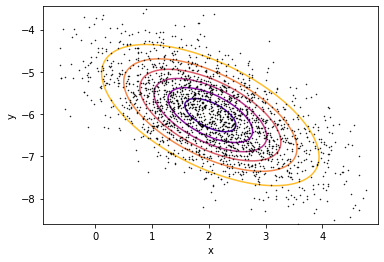

In [11]:
## Make a plot of the unbinned fit
plotting_params = np.hstack((1, best_params_unbinned)) ## need some dummy value for the amplitude
z_best_fit = gauss_2d_fit(xgrid, ygrid, *plotting_params)

plt.figure()
plt.plot(x,y, 'k.', ms=1) # plot data as individual points
plt.contour( xgrid, ygrid, z_best_fit, cmap='plasma_r' )
plt.xlabel("x")
plt.ylabel("y")

# set plotting range
mux, sigx = best_params_unbinned[0], best_params_unbinned[2]
muy, sigy = best_params_unbinned[1], best_params_unbinned[3]
plt.xlim(mux-3*sigx, mux+3*sigx)
plt.ylim(muy-3*sigy, muy+3*sigy)
plt.show()

## **Problem 2: Analyzing optical tweezers data in 3D**




In [3]:
from sklearn.decomposition import PCA ## need this for principle component analysis below
from matplotlib.mlab import psd
import os

In [6]:
time_file = r"C:\Users\Ben\Documents\Python Scripts\data check\time.txt"
data_file = r"C:\Users\Ben\Documents\Python Scripts\data check\data.txt"

t = np.loadtxt(time_file)
d = np.loadtxt(data_file)

## first, load the required data
#tweezer_data = np.load('tweezer_data.npz')
#x_lab = tweezer_data['xlab']
#y_lab = tweezer_data['ylab']
#z_lab = tweezer_data['zlab']
#time = tweezer_data['time']

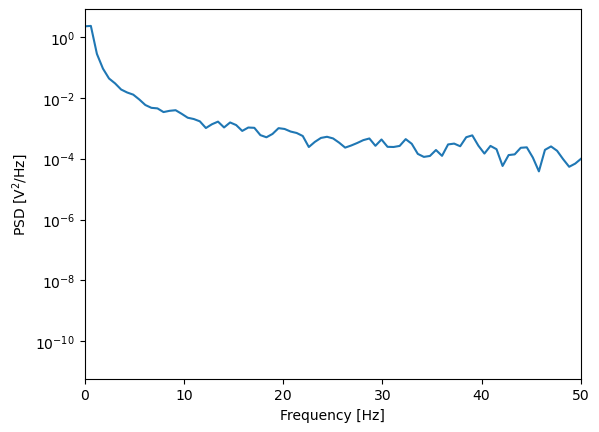

In [14]:
#Fs = 1/(time[1]-time[0]) # sampling rate in Hz (equally spaced time vector)
Fs=10000
## make a n x 3 array of the loaded data
#xlab = np.vstack((x_lab, y_lab, z_lab)).T

NFFT = 2**14 # number of FFT points use in Welch's method
## now make a plot overlaying the PSDs (using Welch's method)
plt.figure()
#coords = ['$x_{lab}$', '$y_{lab}$', '$z_{lab}$']
#for idx, coord in enumerate(coords):
#  curr_psd, freqs = psd(xlab[:,idx], Fs=Fs, NFFT=NFFT)
#  plt.loglog(freqs, curr_psd, label=coord)
datapsd, freqs = psd(d,Fs=Fs,NFFT=NFFT)
plt.semilogy(freqs,datapsd)

plt.xlabel("Frequency [Hz]")
plt.ylabel("PSD [V$^2$/Hz]")
plt.xlim(0,50)
#plt.legend()
plt.show()

So the various PSDs do not look like individual Lorentzians peaked at the resonant frequency in each coordinate. Instead correlations cause multiple peaks to show up corresponding to mixing between the underlying true degress of freedom. In the following we will remove these correlations and then fit the PSDs of the uncorrelated data.

In [5]:
## implement PCA to uncorrelate the lab data and recover the true underlying
## coordinate data. This ends up being only 3 lines of code, but there is a lot
## going on under the hood.
pca = PCA(n_components=3) ## keep 3 components (x,y,z)
pca.fit(xlab) ## fit our data
xorig = pca.transform(xlab) ## reconstruct the original data from the PCA transform

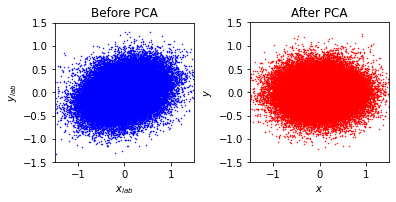

In [6]:
## Make a plot to verify the correlations were removed, e.g. for the x, y coords:
data_sets = [xlab, xorig]
npts_to_plot = 50000 ## limit the number of points to make the plots look better
titles = ["Before PCA", "After PCA"]
colors = ['b', 'r']
plt.figure()
for idx, data in enumerate(data_sets):
  plt.subplot(1,len(data_sets),idx+1)
  plt.plot(data[:npts_to_plot,0], data[:npts_to_plot,1], colors[idx]+'.', ms=1, label="Before PCA")
  plt.gca().set_aspect('equal')
  plt.xlim((-1.5,1.5))
  plt.ylim((-1.5,1.5))
  if(idx == 0):
    plt.xlabel("$x_{lab}$")
    plt.ylabel("$y_{lab}$")
  else:
    plt.xlabel("$x$")
    plt.ylabel("$y$")
  plt.title(titles[idx])

plt.subplots_adjust(wspace=0.4) # avoid cutting off label

plt.show()

In [7]:
## now fit with Lorentzian

def lorentzian(f, f0, gam, cal_fac):
  kb = 1.38e-23 # Boltzmann's constant, SI units
  temp = 293 # Room temp, K
  m = 1e-12 # Mass given in problem set, kg
  omega = 2*np.pi*f
  omega0 = 2*np.pi*f0
  return 1/(cal_fac)**2 * 2*kb*temp/m * gam/((omega0**2 - omega**2)**2 + omega**2*gam**2)

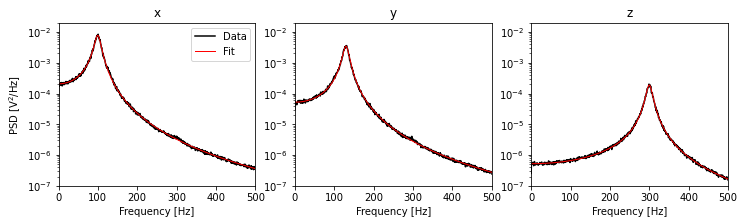

In [8]:
## An even clearer demonstration that the correlations are removed can come
## from plotting the PSDs of the data after PCA. These now can be fit to a
## single Lorentzian and no longer show the multiple peaks:

fig=plt.figure()
coords = ["x", "y", "z"]
cal_facs = [] # array to store the calibration factors

for idx, coord in enumerate(coords):

  dat, freqs = psd(xorig[:,idx], Fs=Fs, NFFT=NFFT)
  init_guess = [freqs[np.argmax(dat)],100,1e-7] # guess for the initial parameters
  best_params, cov = curve_fit(lorentzian, freqs, dat, p0=init_guess)

  plt.subplot(1,3,idx+1)
  plt.semilogy(freqs, dat, 'k', label="Data")
  plt.plot(freqs, lorentzian(freqs,*best_params), 'r', lw=1, label="Fit")
  plt.xlabel('Frequency [Hz]')
  if(idx == 0):
    plt.ylabel("PSD [V$^2$/Hz]")
    plt.legend()
  plt.title(coord)
  plt.xlim(0,500)
  plt.ylim(1e-7, 2e-2)

  cal_facs.append(best_params[2]) ## save the calibration factor for later use

fig.set_size_inches(12,3)

In [9]:
xorig


array([[-0.02453514,  0.37020984, -0.01823633],
       [-0.0451478 ,  0.45362155,  0.00352974],
       [-0.146624  ,  0.47314828,  0.02463273],
       ...,
       [ 0.25723115, -0.19335769,  0.01937844],
       [ 0.15331361, -0.04493088, -0.01809446],
       [ 0.0159511 ,  0.17226375, -0.03454674]])